# Files And Pyspark installation


In [ ]:
from google.colab import files


uploaded = files.upload()

In [ ]:
!pip install pyspark


# PreProcessing
 
1. Handling null values
  - if numeric then replace with mean
  - if categorical then replace with most common
2. Unkown values 
  - remove row if it was less than 100 records in the column with unkown label
  - replace them with most common
3. Change categorical columns to numeric with Label Encoding approach 
4. Correlation matrix
  - between each label and label "y"
  - between each label with other labels

# Frature Engineering

# Logic Regression

# Evalualte Results

 


item <married> is most common in <marital>Column
item <university.degree> is most common in <education>Column
item <no> is most common in <default>Column
item <yes> is most common in <housing>Column
item <no> is most common in <loan>Column
item <cellular> is most common in <contact>Column
item <nonexistent> is most common in <poutcome>Column
Column job has 330 unkown items
------> admin. is the most common in column job
Column marital has 80 unkown items
Column education has 1722 unkown items
------> university.degree is the most common in column education
Column default has 8586 unkown items
------> no is the most common in column default
Column housing has 989 unkown items
------> yes is the most common in column housing
Column loan has 989 unkown items
------> no is the most common in column loan
Column contact has 0 unkown items
Column month has 0 unkown items
Column day_of_week has 0 unkown items
Column poutcome has 0 unkown items
+--------+-----+
| marital|count|
+--------+-----+

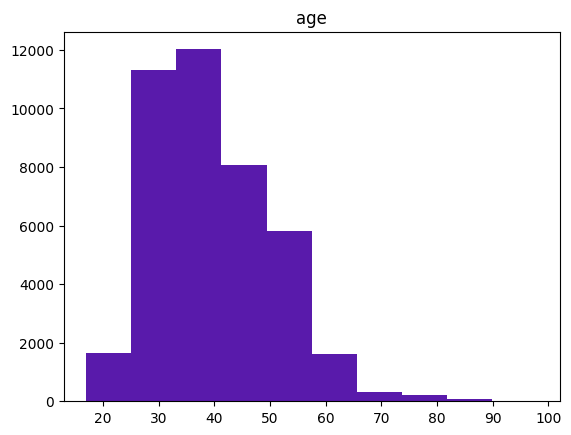

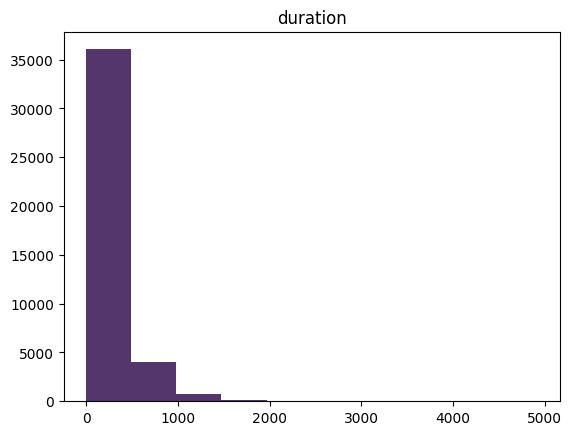

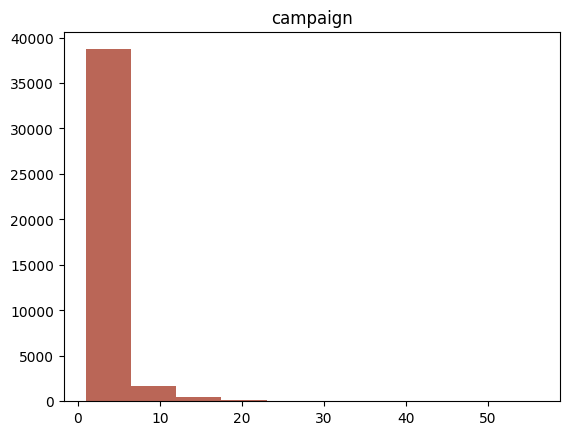

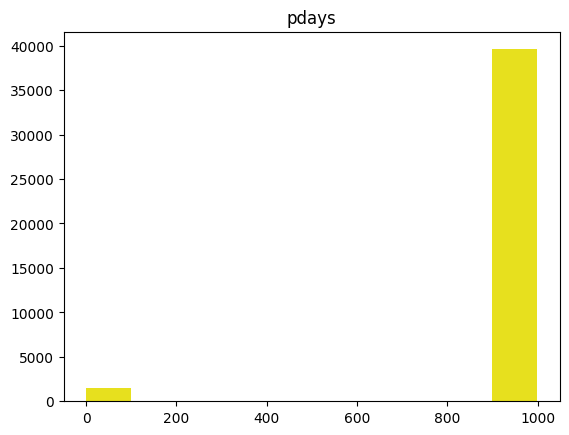

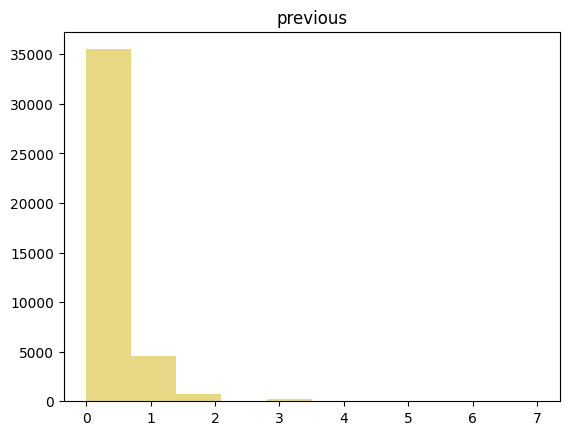

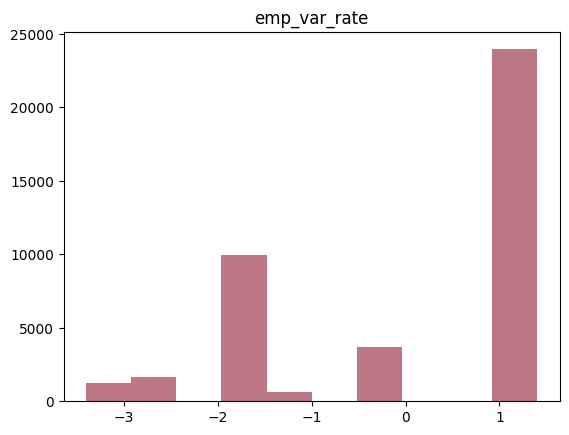

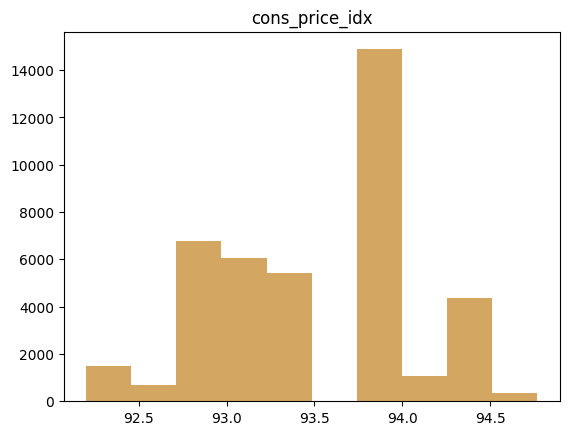

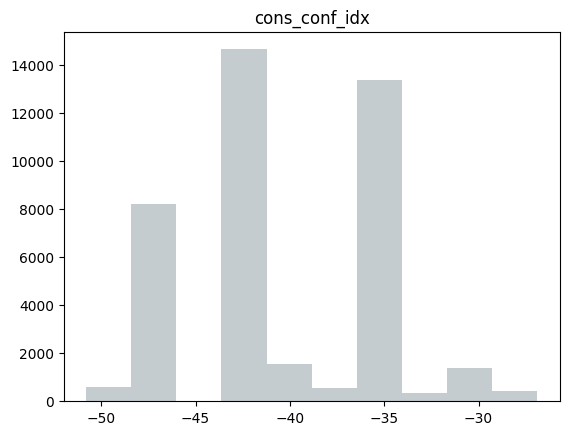

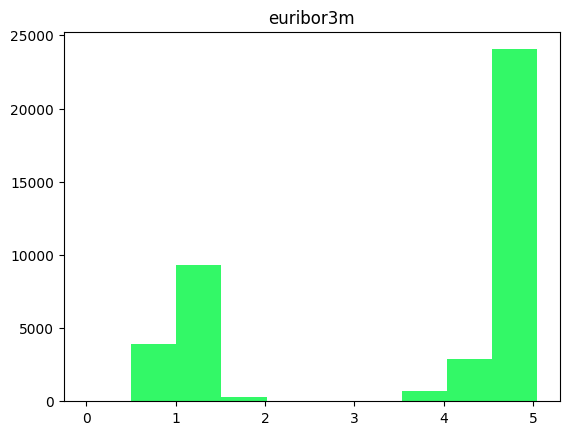

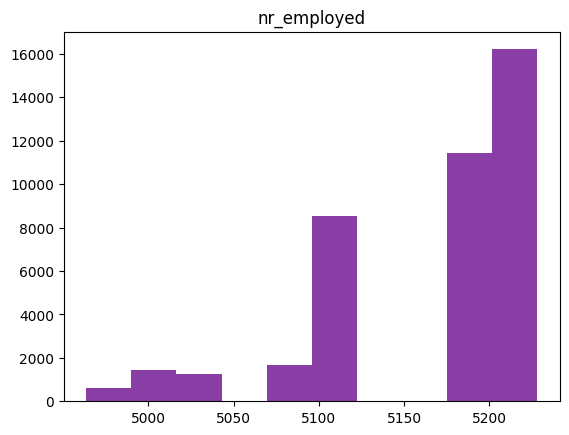

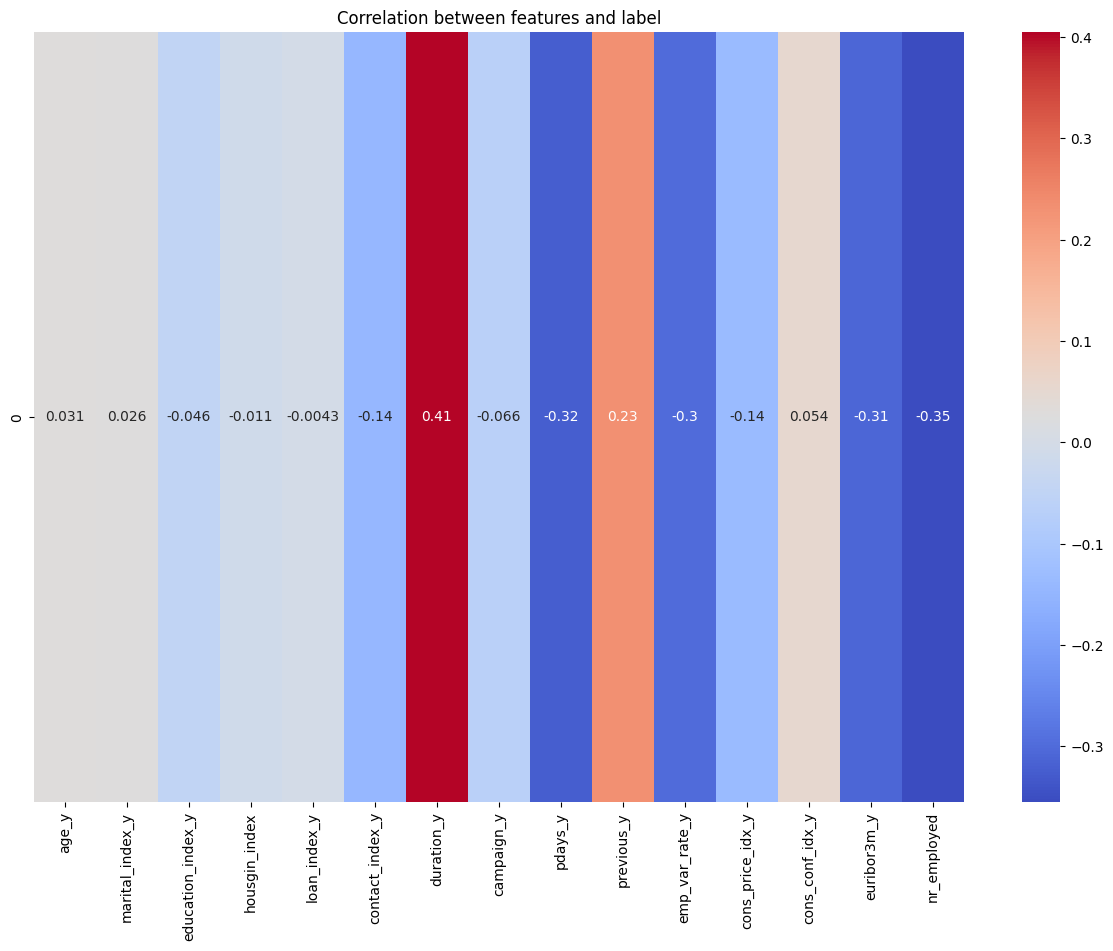

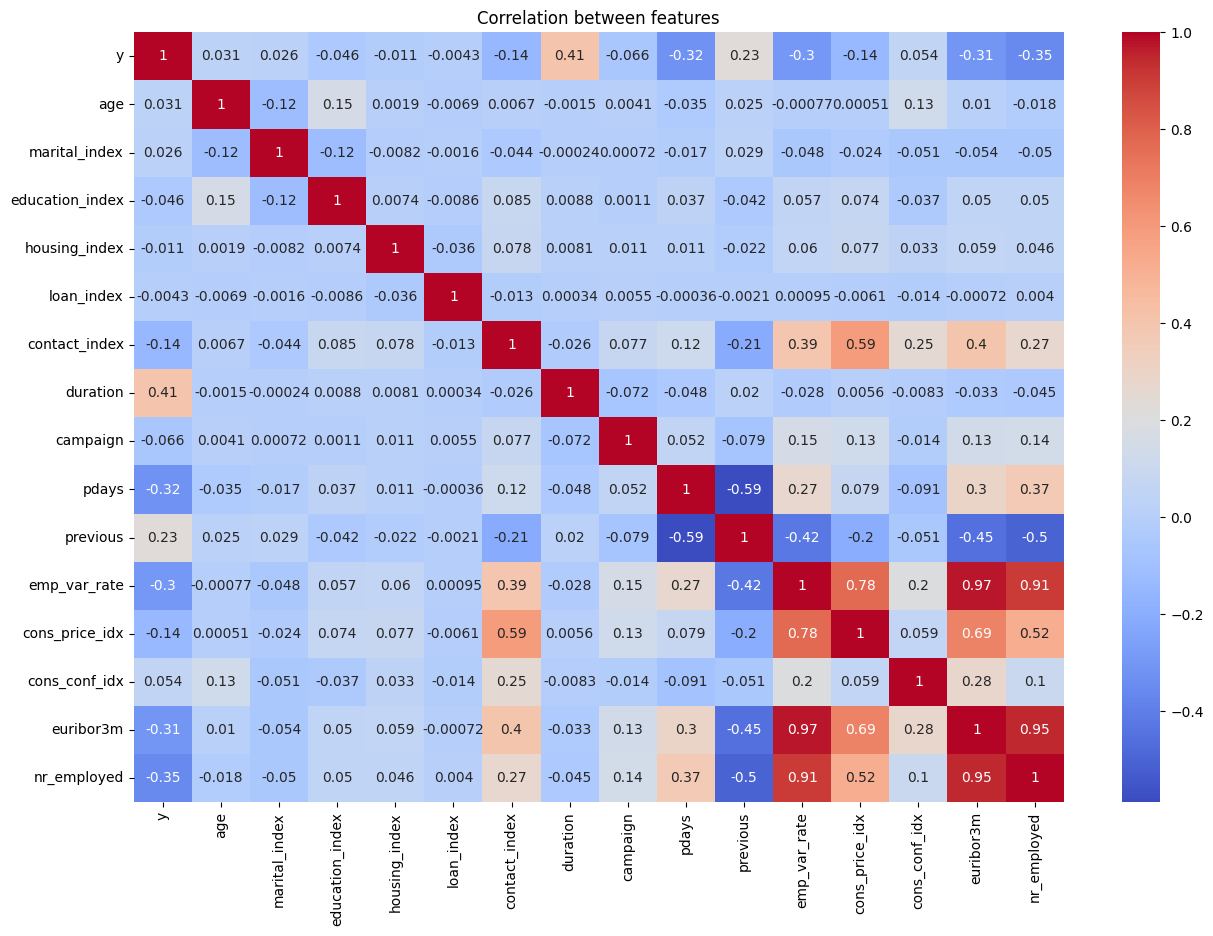

+--------------------+--------+--------+--------+-----+------------+--------------+---------+-----------+---+--------------------+--------------------+----------+
|     scaled_features|duration|campaign|previous|pdays|emp_var_rate|cons_price_idx|euribor3m|nr_employed|  y|       rawPrediction|         probability|prediction|
+--------------------+--------+--------+--------+-----+------------+--------------+---------+-----------+---+--------------------+--------------------+----------+
|[0.0,1.0,0.0,0.93...|     0.0|     4.0|     0.0|999.0|         1.1|        93.994|    4.857|     5191.0|  0|[4.56435490695476...|[0.98969079016735...|       0.0|
|[2.03334688897925...|     1.0|     1.0|     1.0|999.0|        -1.1|        94.199|    0.886|     4963.6|  0|[1.95426913915492...|[0.87591140233414...|       0.0|
|[6.10004066693777...|     3.0|     1.0|     0.0|999.0|         1.1|        93.994|    4.856|     5191.0|  0|[4.55138377543961...|[0.98955760250031...|       0.0|
|[6.10004066693777...|

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import random

spark = SparkSession.builder.appName("Bank Marketing").getOrCreate()

df = spark.read.csv("ML_hw_dataset.csv", header=True, inferSchema=True)

num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
str_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
categorical_cols = [ 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

mean_values = df.select([mean(c).alias(c) for c in num_cols]).collect()[0].asDict()

# For null values in columns with int and double type, replace with mean
for column in num_cols:
  df = df.withColumn(column, when(col(column).isNull(), mean_values[column]).otherwise(col(column)))
# Handle categorical null values by replacing them with mode 
for column in categorical_cols:
  mode = df.groupBy(column).count().orderBy('count', ascending=False).limit(1).select(column).collect()[0][0]
  print(f"item <{mode}> is most common in <{column}>Column")
  df = df.fillna(mode, subset=column)

# For null unkown valuse in columns with string type, if it was less than 100 remove and if it was more thanreplace with most common
for column in str_cols:
  count_unknown = df.filter(col(column) == 'unknown').count()
  print(f"Column {column} has {count_unknown} unkown items")
  if count_unknown > 0 and count_unknown < 100:
    df = df.filter(col(column) != 'unknown')
  elif count_unknown >= 100 :
    most_common = df.groupBy(column).count().orderBy(col("count").desc()).collect()[0][0]
    print(f"------> {most_common} is the most common in column {column}")
    df = df.withColumn(column, when(col(column) == 'unknown', most_common).otherwise(col(column)))

# BarChart for numeric cols
for item in num_cols:
  color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
  df.toPandas().hist(column = item, grid=False, color = color)

#Show Each value count for categorical cols
for item in categorical_cols:
  df.groupBy(item).count().orderBy(col("count").desc()).show() 

# Change categortical values to numeric
for column in categorical_cols:
  indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
  df = indexer.fit(df).transform(df)

#Checking correlation between features and label
corr_df = df.select(corr('age', 'y').alias('age_y'),
                    corr('marital_index', 'y').alias('marital_index_y'),
                    corr('education_index', 'y').alias('education_index_y'),
                    corr('housing_index', 'y').alias('housgin_index'),
                    corr('loan_index', 'y').alias('loan_index_y'),
                    corr('contact_index', 'y').alias('contact_index_y'),
                    corr('duration', 'y').alias('duration_y'),
                    corr('campaign', 'y').alias('campaign_y'),
                    corr('pdays', 'y').alias('pdays_y'),
                    corr('previous', 'y').alias('previous_y'),
                    corr('emp_var_rate', 'y').alias('emp_var_rate_y'),
                    corr('cons_price_idx', 'y').alias('cons_price_idx_y'),
                    corr('cons_conf_idx', 'y').alias('cons_conf_idx_y'),
                    corr('euribor3m', 'y').alias('euribor3m_y'),
                    corr('nr_employed', 'y').alias('nr_employed')
                    )
                    
corr_df.show()

# Visualize correlations
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(15,10))
sns.heatmap(corr_df.toPandas(), annot=True, cmap='coolwarm')
plt.title('Correlation between features and label')
plt.show()

#Checking correlation between features
corr_all = df.select("y", "age","marital_index", "education_index", "housing_index", "loan_index", "contact_index", "duration", "campaign", "pdays", "previous", "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed").toPandas()
corr = corr_all.corr()

plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between features')
plt.show()

# Create feature col with Selected columns and then normalize it
assembler = VectorAssembler(inputCols=["duration", "pdays", "previous", "emp_var_rate", "cons_price_idx", "euribor3m", "nr_employed"], outputCol="features")
df = assembler.transform(df)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

df.toPandas().to_csv('bank.csv')

#Selecting relevant columns for logistic regression
df = df.select("scaled_features", "duration", "campaign", "previous", "pdays", "emp_var_rate", "cons_price_idx", "euribor3m", "nr_employed", "y")

#Splitting the data into training and testing sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

#Running logistic regression algorithm
lr = LogisticRegression(featuresCol="scaled_features", labelCol="y")
lr_model = lr.fit(train_data)
predictions = lr_model.transform(test_data)
predictions.limit(100).show()

#Evaluating the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="y")
accuracy = evaluator.evaluate(predictions)
print("Accuracy of logistic regression: ", accuracy)

true_positive = predictions.filter(col("prediction") == 1.0).filter(col("y") == 1.0).count()
false_positive = predictions.filter(col("prediction") == 1.0).filter(col("y") == 0.0).count()
true_negative = predictions.filter(col("prediction") == 0.0).filter(col("y") == 0.0).count()
false_negative = predictions.filter(col("prediction") == 0.0).filter(col("y") == 1.0).count()

accuracy = (true_positive + true_negative) / float(predictions.count())
precision = true_positive / float(true_positive + false_positive)
recall = true_positive / float(true_positive + false_negative)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="y")
auc = evaluator.evaluate(predictions)
print("AUC: {}".format(auc))

# SVM

In [10]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import LinearSVC
from pyspark.sql.types import DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

spark = SparkSession.builder.appName("Bank Marketing").getOrCreate()

df = spark.read.csv("ML_hw_dataset.csv", header=True, inferSchema=True)

num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
str_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
categorical_cols = [ 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

mean_values = df.select([mean(c).alias(c) for c in num_cols]).collect()[0].asDict()

# For null values in columns with int and double type, replace with mean
for column in num_cols:
  df = df.withColumn(column, when(col(column).isNull(), mean_values[column]).otherwise(col(column)))
# Handle categorical null values by replacing them with mode 
for column in categorical_cols:
  mode = df.groupBy(column).count().orderBy('count', ascending=False).limit(1).select(column).collect()[0][0]
  df = df.fillna(mode, subset=column)

# For null unkown valuse in columns with string type, if it was less than 100 remove and if it was more thanreplace with most common
for column in str_cols:
  count_unknown = df.filter(col(column) == 'unknown').count()
  if count_unknown > 0 and count_unknown < 100:
    df = df.filter(col(column) != 'unknown')
  elif count_unknown >= 100 :
    most_common = df.groupBy(column).count().orderBy(col("count").desc()).collect()[0][0]
    df = df.withColumn(column, when(col(column) == 'unknown', most_common).otherwise(col(column)))

# change outliers in num_cols with avg_val
for col_name in num_cols:
    avg_val = df.select(mean(col(col_name))).collect()[0][0]
    std_dev = df.select(stddev(col(col_name))).collect()[0][0]
    lower_bound = avg_val - 3*std_dev
    upper_bound = avg_val + 3*std_dev
    df = df.withColumn(col_name, \
                       when(col(col_name) < lower_bound, avg_val)\
                        .when(col(col_name) > upper_bound, avg_val)\
                        .otherwise(col(col_name)))


 # Change categortical values to numeric
for column in categorical_cols:
  indexer = StringIndexer(inputCol=column, outputCol=column+"_index")
  df = indexer.fit(df).transform(df)
   
 
# Create feature col with Selected columns and then normalize it
assembler = VectorAssembler(inputCols=["duration", "pdays", "previous", "emp_var_rate", "cons_price_idx", "euribor3m", "nr_employed"], outputCol="features")
df = assembler.transform(df)
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)


#Selecting relevant columns for logistic regression
df = df.select("scaled_features", "y")

#Splitting the data into training and testing sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

#Running SVM algorithm
svm = LinearSVC(featuresCol="scaled_features", labelCol="y", maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)

predictions = svm_model.transform(test_data)
predictions.show(20)
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='y')
auc = evaluator.evaluate(predictions)
print('AUC:', auc)


true_positive = predictions.filter(col("prediction") == 1.0).filter(col("y") == 1.0).count()
false_positive = predictions.filter(col("prediction") == 1.0).filter(col("y") == 0.0).count()
true_negative = predictions.filter(col("prediction") == 0.0).filter(col("y") == 0.0).count()
false_negative = predictions.filter(col("prediction") == 0.0).filter(col("y") == 1.0).count()

accuracy = (true_positive + true_negative) / float(predictions.count())
precision = true_positive / float(true_positive + false_positive)
recall = true_positive / float(true_positive + false_negative)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))

+--------------------+---+--------------------+----------+
|     scaled_features|  y|       rawPrediction|prediction|
+--------------------+---+--------------------+----------+
|[0.0,1.0,0.0,0.93...|  0|[1.34814626435348...|       0.0|
|[9.66183574879227...|  0|[0.97889557993579...|       0.0|
|[0.00289855072463...|  0|[1.34659352166775...|       0.0|
|[0.00289855072463...|  0|[1.34660545322051...|       0.0|
|[0.00386473429951...|  0|[0.96937055046757...|       0.0|
|[0.00386473429951...|  0|[0.95818090717207...|       0.0|
|[0.00386473429951...|  0|[0.92890441750386...|       0.0|
|[0.00386473429951...|  0|[1.34611571261505...|       0.0|
|[0.00483091787439...|  0|[-0.5583525034979...|       1.0|
|[0.00483091787439...|  0|[0.96494904925869...|       0.0|
|[0.00483091787439...|  0|[0.95760764569727...|       0.0|
|[0.00483091787439...|  0|[0.92833115602906...|       0.0|
|[0.00483091787439...|  0|[0.90565882872637...|       0.0|
|[0.00483091787439...|  0|[0.90606450152026...|       0.